## Machine learning analysis of 12,991 potentially-informative features derived from molecular modeling* for thier use in prediciting experimental $k_{cat}$, $K_M$, and $k_{cat}/K_M$

### *modern Rosetta protocol

We are interested in using machine learning tools to predict enzyme function from protein structure. In order to put this in machine learning tools, we need to identify informative features from the molecular modeling feature set $F$. 

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt 
import pandas 
plt.style.use('ggplot')
from sklearn import preprocessing, linear_model, ensemble, feature_selection, model_selection, pipeline 

In [3]:
import pandas 
from bokeh.io import push_notebook, show, output_notebook
from bokeh.layouts import row, column
from bokeh.plotting import figure
output_notebook()

Loading BokehJS ...

In [4]:
! pwd

/Users/alex/Documents/bglb_family/machine_learning


## Features! 

In [5]:
! rsync -avz ca:/share/work/alex/bigger_constraint_exploration_run/data.h5 . 

/home/carlin/.bashrc: line 3: bind: warning: line editing not enabled
receiving file list ... done

sent 16 bytes  received 88 bytes  69.33 bytes/sec
total size is 23122290  speedup is 222329.71


In [6]:
feat = pandas.read_hdf('data.h5')
feat.head()

0                                                                 \
         label fa_atr fa_rep fa_sol fa_intra_atr_xover4 fa_intra_rep_xover4   
A192S  weights    1.0   0.55    1.0                 1.0                0.55   
A227W  weights    1.0   0.55    1.0                 1.0                0.55   
A236E  weights    1.0   0.55    1.0                 1.0                0.55   
A249E  weights    1.0   0.55    1.0                 1.0                0.55   
A306N  weights    1.0   0.55    1.0                 1.0                0.55   

                                                              \
      fa_intra_sol_xover4 lk_ball lk_ball_iso lk_ball_bridge   
A192S                 1.0    0.92       -0.38          -0.33   
A227W                 1.0    0.92       -0.38          -0.33   
A236E                 1.0    0.92       -0.38          -0.33   
A249E                 1.0    0.92       -0.38          -0.33   
A306N                 1.0    0.92       -0.38          -0.33   

             ...          447                                            \
             ...        omega fa_dun_dev fa_dun_rot fa_dun_semi p_aa_pp   
A192S        ...          0.0        0.0        0.0         0.0     0.0   
A227W        ...          0.0        0.0        0.0         0.0     0.0   
A236E        ...          0.0        0.0        0.0         0.0     0.0   
A249E        ...          0.0        0.0        0.0         0.0     0.0   
A306N        ...          0.0        0.0        0.0         0.0     0.0   

                                                            
      hxl_tors  ref rama_prepro    total sequence_position  
A192S      0.0  0.0         0.0  7.99935               446  
A227W      0.0  0.0         0.0  6.23068               446  
A236E      0.0  0.0         0.0  4.63702               446  
A249E      0.0  0.0         0.0  7.04588               446  
A306N      0.0  0.0         0.0  4.99261               446  

[5 rows x 12991 columns]

In [7]:
feat.shape

(201, 12991)

Before we get in to the targets, let's get rid of as many of these features as we can. Having 12,991 features for only 200 samples is not great!

First, let's get rid of string features, since they are likely labels. Easiest way to do this is to get all the features that are float64. 

In [8]:
feat = feat.select_dtypes(['float64'])
feat.shape

(201, 12095)

And, let's get rid of features with 0 variance. 

In [9]:
zero_variance_features = []
for col in feat.columns:
    if feat[col].std() == 0.0:
        zero_variance_features.append(col)
feat = feat.drop(zero_variance_features, axis=1)
feat.shape

(201, 8401)

Ooooh, that is good, we get rid of another 3,694 useless features this way! 

Now that we have a "reasonable" set of features. Let's try looking at the targets. 

## Machine learning targets! 

In [10]:
targets = pandas.read_csv('../data_sets/speculative_targets.csv', index_col=0)
targets.head()

,kcat,km,kcatkm,expression
mutant_name,,,,
S14A,-0.439333,0.217484,-0.651460,1
T15A,-0.156314,0.025306,-0.176657,1
S16A,-0.756962,0.447468,-1.199275,1
S17A,-0.016087,0.567026,-0.577999,1
S17E,-0.137625,0.165541,-0.298065,1


Now, let's see if we can join these and get something out 

In [11]:
J = feat.join(targets)
J.head()

/Users/alex/anaconda3/lib/python3.6/site-packages/pandas/tools/merge.py:536: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


,"(0, fa_rep)","(0, fa_intra_rep_xover4)","(0, lk_ball)","(0, lk_ball_iso)","(0, lk_ball_bridge)","(0, lk_ball_bridge_uncpl)","(0, omega)","(0, fa_dun_dev)","(0, fa_dun_rot)","(0, fa_dun_semi)",...,"(447, lk_ball_bridge)","(447, lk_ball_bridge_uncpl)","(447, fa_elec)","(447, fa_intra_elec)","(447, hbond_sc)","(447, total)",kcat,km,kcatkm,expression
A192S,0.55,0.55,0.92,-0.38,-0.33,-0.33,0.48,0.69,0.76,0.78,...,-0.05648,-0.39996,-3.92200,0.83169,-1.52653,7.99935,0.031408,0.007748,0.028609,1.0
A227W,0.55,0.55,0.92,-0.38,-0.33,-0.33,0.48,0.69,0.76,0.78,...,-0.06749,-0.46456,-3.80166,0.95059,-1.45225,6.23068,-0.362874,0.531479,-0.889390,1.0
A236E,0.55,0.55,0.92,-0.38,-0.33,-0.33,0.48,0.69,0.76,0.78,...,-0.07601,-0.40267,-4.09516,0.90852,-1.65660,4.63702,NaN,NaN,NaN,0.0
A249E,0.55,0.55,0.92,-0.38,-0.33,-0.33,0.48,0.69,0.76,0.78,...,-0.05857,-0.41367,-4.02934,0.82877,-1.41720,7.04588,NaN,NaN,NaN,0.0
A306N,0.55,0.55,0.92,-0.38,-0.33,-0.33,0.48,0.69,0.76,0.78,...,-0.08060,-0.41687,-4.15582,0.97967,-1.53085,4.99261,NaN,NaN,NaN,NaN


OK, that'll work! Now, let's make a nice dict where we can do each of kcat, km, and kcat/KM at the same time! 

In [14]:
# opts = dict(plot_width=600, plot_height=400, min_border=0)
# p1 = figure(**opts)
# r1 = p1.circle([1,2,3], [4,5,6], size=20)

# p2 = figure(**opts)
# r2 = p2.circle([1,2,3], [4,5,6], size=20)

# # get a handle to update the shown cell with
# t = show(row(p1, p2), notebook_handle=True)

In [15]:
tgts = 'kcat km kcatkm'.split()

In [24]:
runs = []
for tgt in tgts:    
    J = feat.join(targets[tgt]).dropna()
    print(J.shape)
    
    d = J.corr()[[tgt]]
    d['abs'] = d[tgt].map(abs)
    d = d.sort_values('abs', ascending=False).head(11).iloc[1:,]
    print(d)
    
    X = J.ix[:,0:-1]
    y = J.ix[:,-1].ravel()
    pkg = tgt, X, y, d.index 
    runs.append(pkg)

/Users/alex/anaconda3/lib/python3.6/site-packages/pandas/tools/merge.py:536: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


(103, 8402)
                                 kcat       abs
(400, fa_dun_semi)           0.473890  0.473890
(14, fa_intra_sol_xover4)    0.470411  0.470411
(14, fa_intra_rep_xover4)   -0.462296  0.462296
(436, fa_dun_dev)           -0.446616  0.446616
(381, fa_atr)               -0.442565  0.442565
(440, fa_elec)              -0.438466  0.438466
(400, lk_ball_bridge_uncpl)  0.436561  0.436561
(14, lk_ball_bridge_uncpl)   0.430360  0.430360
(399, fa_rep)               -0.426970  0.426970
(399, lk_ball_bridge)        0.426061  0.426061
(103, 8402)
                                   km       abs
(119, lk_ball_bridge)        0.406687  0.406687
(123, lk_ball_bridge)        0.406633  0.406633
(169, lk_ball)               0.400649  0.400649
(133, lk_ball_iso)          -0.399765  0.399765
(133, fa_atr)               -0.395215  0.395215
(401, hxl_tors)              0.391078  0.391078
(119, fa_atr)                0.384923  0.384923
(119, lk_ball_bridge_uncpl)  0.378727  0.378727
(123, lk_ball_br

/Users/alex/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


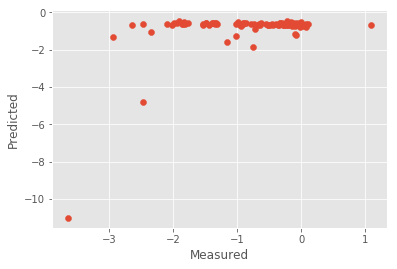

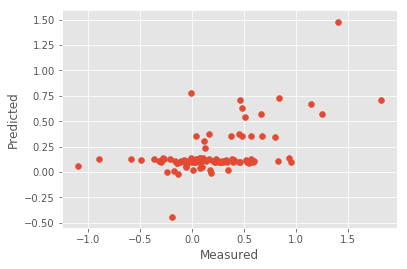

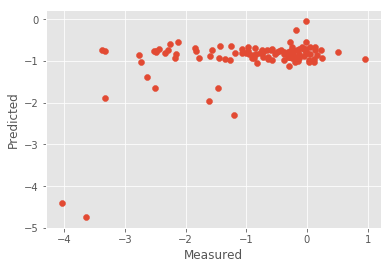

In [37]:
# reduced features 

pts = []
for tgt, X, y, d_index in runs:
#     print(tgt, X.shape, y.shape, d_index) 
    reduced_features = X[d_index]
    params = {}
    
    pln = pipeline.Pipeline([
        ('scaler', preprocessing.StandardScaler()),
        ('clf', linear_model.ElasticNetCV(cv=2, max_iter=1e4)),
    ])
    
    clf = model_selection.GridSearchCV(pln, params, cv=5)
    preds = model_selection.cross_val_predict(clf, reduced_features, y, cv=10)
    fig, ax = plt.subplots()
    ax.scatter(y, preds)
    ax.set(xlabel='Measured', ylabel='Predicted')
    
#     opts = dict(plot_width=300, plot_height=300)
#     plot = figure(**opts)
#     plot.circle(y, preds)
#     pts.append(plot)
    
# show(row(pts), notebook_handle=True)    

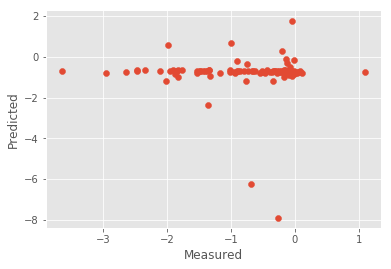

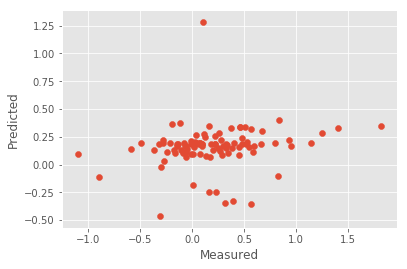

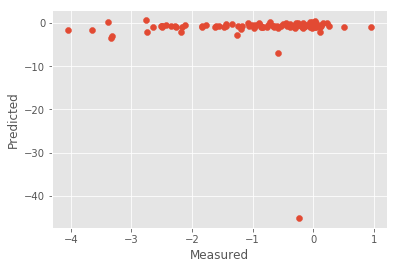

In [36]:
# reduced features 

pts = []
for tgt, X, y, d_index in runs:
#     print(tgt, X.shape, y.shape, d_index) 
    reduced_features = X[d_index]
    params = {}
    
    pln = pipeline.Pipeline([
        ('scaler', preprocessing.StandardScaler()),
        ('clf', linear_model.ElasticNetCV(cv=2, max_iter=1e4)),
    ])
    
    clf = model_selection.GridSearchCV(pln, params, cv=5)
    preds = model_selection.cross_val_predict(clf, X, y, cv=10)
    fig, ax = plt.subplots()
    ax.scatter(y, preds)
    ax.set(xlabel='Measured', ylabel='Predicted')
    
#     opts = dict(plot_width=300, plot_height=300)
#     plot = figure(**opts)
#     plot.circle(y, preds)
#     pts.append(plot)
    
# show(row(pts), notebook_handle=True)    

In [38]:
# pts = []
# for tgt, X, y, d_index in runs:
#     print(tgt, X.shape, y.shape) 
#     params = {}
    
#     pln = pipeline.Pipeline([
#         ('scaler', preprocessing.StandardScaler()),
#         ('clf', linear_model.ElasticNetCV(cv=5, max_iter=1e9)),
#     ])
    
#     clf = model_selection.GridSearchCV(pln, params)
#     preds = model_selection.cross_val_predict(clf, X, y, cv=4)
    
#     opts = dict(plot_width=300, plot_height=300)
#     plot = figure(**opts)
#     plot.circle(y, preds)
#     pts.append(plot)
    
# show(row(pts), notebook_handle=True)    